In [59]:
import pandas as pd
import os
from models import *
import seaborn as sns
import matplotlib.pyplot as plt

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

path = './osfstorage-archive/Experiment 1/twostep_data_study1/'
paths = [path + x for x in os.listdir(path) if x.endswith('.csv')]

In [60]:
def read_fn(fn):
    with open(fn) as f:
        lines = f.readlines()
    lines = [x.strip() for x in lines]
    i = min([i for i, x in enumerate(lines) if 'twostep_instruct_9' in x])
    lines = lines[i:]
    lines = [x.split(',') for x in lines]

    df = pd.DataFrame(lines[1:])
    return df

# rename columns
"""A = trial_num
B = drift 1 (probability of reward after second stage option 1)
C = drift 2 (probability of reward after second stage option 2)
D = drift 3 (probability of reward after second stage option 3)
E = drift 4 (probability of reward after second stage option 4)
F = stage 1 response (left/right)
G = stage 1 selected stimulus (1/2 - note this is redundant with the response as the stage 1 options do not switch locations)
H = stage 1 RT
I = transition (common = TRUE; rare = FALSE)
J = stage 2 response (left/right)
K = stage 2 selected stimulus (1/2 - note this is redundant with response as the stage 2 options also do not switch locations)
L =  stage 2 state (identity 2 or 3)
M = stage 2 RT
N = reward (1= yes; 0=no)
O = redundant task variable, always set to 1"""

columns = """A = trial_num
B = drift1
C = drift2
D = drift3
E = drift4
F = choice1
G = choice1_int
H = stage1_RT
I = common_trans
J = choice2
K = choice2_int
L = stage2
M = stage2_RT
N = reward
O = redundant"""
columns = columns.split('\n')
columns = [x.split(' = ')[1] for x in columns]

'A = trial_num\nB = drift 1 (probability of reward after second stage option 1)\nC = drift 2 (probability of reward after second stage option 2)\nD = drift 3 (probability of reward after second stage option 3)\nE = drift 4 (probability of reward after second stage option 4)\nF = stage 1 response (left/right)\nG = stage 1 selected stimulus (1/2 - note this is redundant with the response as the stage 1 options do not switch locations)\nH = stage 1 RT\nI = transition (common = TRUE; rare = FALSE)\nJ = stage 2 response (left/right)\nK = stage 2 selected stimulus (1/2 - note this is redundant with response as the stage 2 options also do not switch locations)\nL =  stage 2 state (identity 2 or 3)\nM = stage 2 RT\nN = reward (1= yes; 0=no)\nO = redundant task variable, always set to 1'

In [61]:
# fn = [x for x in paths if '3A1COHJ8NJVPKFSRS1WC7SOUCMHH84' in x][0]
fn = paths[10]
print(fn)
df = read_fn(fn)
df.columns = columns
df.drop('redundant', axis=1, inplace=True)


df.loc[:, ['drift1', 'drift2', 'drift3', 'drift4']] = df.loc[:, ['drift1', 'drift2', 'drift3', 'drift4']].astype(float)

# drop rows where reward is -1. These seem to be where the participant did not respond in time, i.e. RT=2502?
df.reward = df.reward.astype(int)
df = df[df.reward != -1]

# reset index
df.reset_index(drop=True, inplace=True)

df.common_trans = df.common_trans.apply(lambda x: x == 'true')
df.choice1_int = df.choice1_int.astype(int) - 1
df.choice2_int = df.choice2_int.astype(int) - 1
df.stage2 = df.stage2.astype(int) - 2

df_rw = df.loc[:, ['drift1', 'drift2', 'drift3', 'drift4']]

./osfstorage-archive/Experiment 1/twostep_data_study1/3TDXMTX3CBU2CWKN54HZNQTI56EI6N.csv


In [62]:
model = Model(alpha=0.15, beta_mb=1.0, beta_mf0=0.0, beta_mf1=0.0)

In [63]:
drifts_iterator = (x[1] for x in df_rw.iterrows())
outs = model.perform_trials(drifts_iterator, save_Qs=True)
outs = pd.DataFrame(outs, columns=['choice1', 'stage2', 'choice2', 'reward', 'Qstage2', 'Q_MF0', 'Q_MF1'])

In [64]:
Qstage2 = outs.Qstage2
Qstage2 = np.stack(Qstage2.values)
Qstage2[0]
Qstage2[1]

array([[0.5  , 0.575],
       [0.5  , 0.5  ]])

array([[0.575, 0.575],
       [0.5  , 0.5  ]])

<AxesSubplot:>

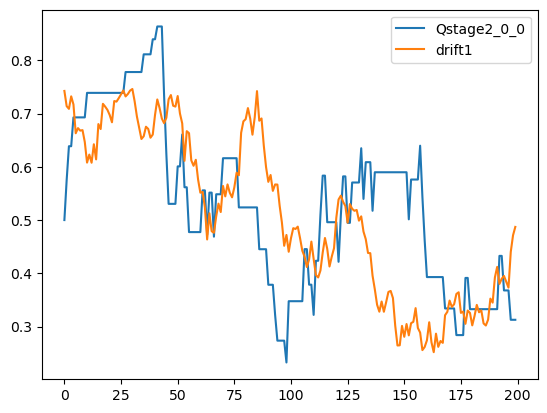

In [65]:
plt.plot(Qstage2[:, 0, 0], label='Qstage2_0_0')
df_rw.iloc[:, 0].plot(label='drift1')
plt.legend()

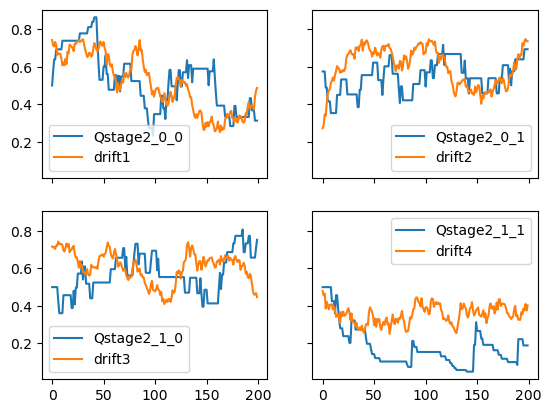

In [66]:
# Do the previous four plots in one big figure, a 2x2 grid
fig, axes = plt.subplots(2, 2, sharex=True, sharey=True)
axes = axes.flatten()
for i in range(4):
    _ = axes[i].plot(Qstage2[:, i//2, i%2], label='Qstage2_{}_{}'.format(i//2, i%2))
    _ = axes[i].plot(df.loc[:, 'drift{}'.format(i+1)], label='drift{}'.format(i+1))
    # df.loc[:, 'drift{}'.format(i+1)].plot(label='drift{}'.format(i+1))
    _ = axes[i].legend()

In [67]:
outs['choice1'][1:].values

array([0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0,
       0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,
       0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,
       1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0,
       0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0,
       0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1,
       1])

In [68]:
outs['choice1'][:-1].values

array([0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1,
       0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,
       0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1,
       0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1,
       1])

In [69]:
# P(stay) for previous rewarded vs unrewarded trials, for common and rare transitions
# T/F array
stayed = outs['choice1'][1:].values == outs['choice1'][:-1].values
# First trial is neither a stay nor a switch
outs['stay'] = [None] + stayed.tolist()


# prev rewarded and stayed
prev_rew_stayed = outs['stay'][1:].values & (outs['reward'][:-1].values == 1)
# prev unrewarded and stayed
prev_unrew_stayed = outs['stay'][1:].values & (outs['reward'][:-1].values == 0)
# prev rewarded and switched
prev_rew_switched = ~outs['stay'][1:].values & (outs['reward'][:-1].values == 1)
# prev unrewarded and switched
prev_unrew_switched = ~outs['stay'][1:].values & (outs['reward'][:-1].values == 0)

# prev rewarded
prev_rew = (outs['reward'][:-1].values == 1)
outs['prev_rew'] = [None] + prev_rew.tolist()
outs['common_trans'] = outs['stage2'] == outs['choice1']
outs['prev_common_trans'] = [None] + outs['common_trans'][:-1].tolist()

df_outs = outs.iloc[1:, :]


In [70]:
outs.loc[:, ['choice1', 'stage2', 'choice2', 'reward', 'stay', 'prev_rew', 'common_trans', 'prev_common_trans']].head(10)

,choice1,stage2,choice2,reward,stay,prev_rew,common_trans,prev_common_trans
0,0,0,1,1,None,None,True,None
1,0,0,0,1,True,True,True,True
2,0,0,0,1,True,True,True,True
3,0,0,1,0,True,True,True,True
4,0,0,0,1,True,False,True,True
5,1,0,1,0,False,True,False,True
6,1,1,0,0,True,False,True,False
7,0,1,0,0,False,False,False,True
8,0,0,1,0,True,False,True,False
9,0,1,1,0,True,False,False,True


<Figure size 640x480 with 0 Axes>

<BarContainer object of 4 artists>

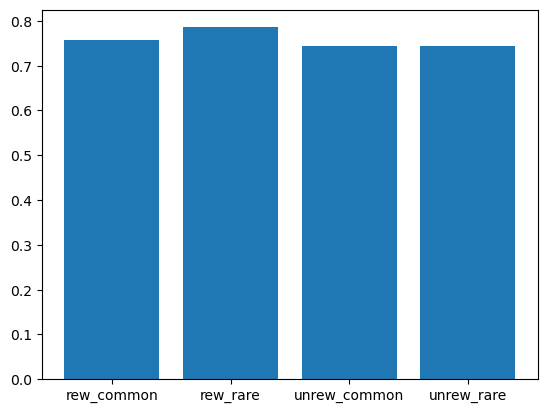

In [71]:
stay_prob_rew_common = df_outs.loc[df_outs.prev_rew & df_outs.prev_common_trans].stay
stay_prob_rew_rare = df_outs.loc[df_outs.prev_rew & ~df_outs.prev_common_trans].stay
stay_prob_unrew_common = df_outs.loc[~df_outs.prev_rew & ~df_outs.prev_common_trans].stay
stay_prob_unrew_rare = df_outs.loc[~df_outs.prev_rew & ~df_outs.prev_common_trans].stay
# plot stay probs with error bars for each of the four conditions
# prev rewarded and stayed
plt.figure()
plt.bar([1, 2, 3, 4], [stay_prob_rew_common.mean(), stay_prob_rew_rare.mean(), stay_prob_unrew_common.mean(), stay_prob_unrew_rare.mean()],
        tick_label=['rew_common', 'rew_rare', 'unrew_common', 'unrew_rare'])


Text(0, 0.5, 'P(stay)')

[Text(1, 0, 'prev rewarded'), Text(3, 0, 'prev unrewarded')]

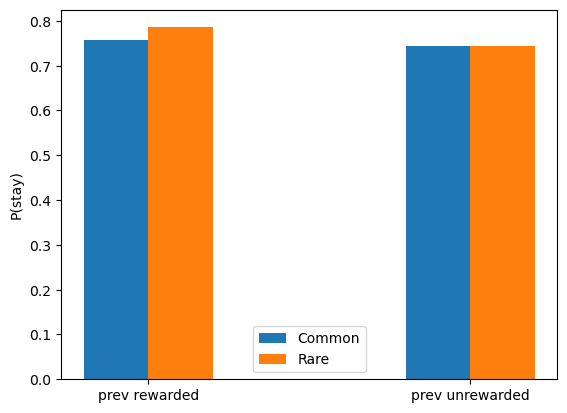

In [72]:
bar_width = 0.4

# Plotting
fig, ax = plt.subplots()
bars1 = ax.bar([0.8, 2.8], [stay_prob_rew_common.mean(), stay_prob_unrew_common.mean()], bar_width, label='Common', capsize=5)
bars2 = ax.bar([1.2, 3.2], [stay_prob_rew_rare.mean(), stay_prob_unrew_rare.mean()], bar_width, label='Rare', capsize=5)

# ax.set_xlabel('Reward')
ax.set_ylabel('P(stay)')
# ax.set_title('Experiment 1')
ax.set_xticks([1, 3])
ax.set_xticklabels(['prev rewarded', 'prev unrewarded'])

plt.legend()

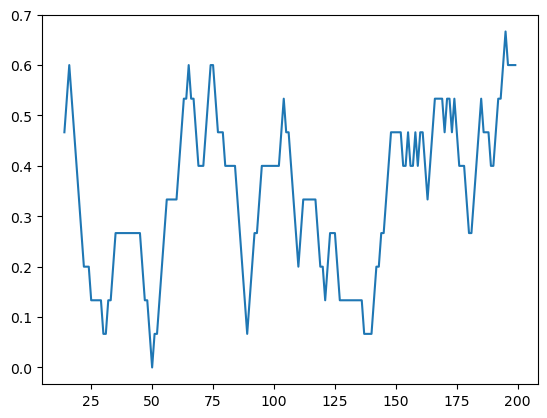

In [8]:
outs = np.array(outs)

# weighted moving average of choice1
choice1 = outs[:, 0]
choice1 = pd.Series(choice1)
choice1 = choice1.rolling(15).mean()
plt.plot(choice1)


In [18]:
bar = np.array([[0, 1],[2,3]])
bar[0][1]
bar[0, 1]
bar[(1,1)]

1

1

3

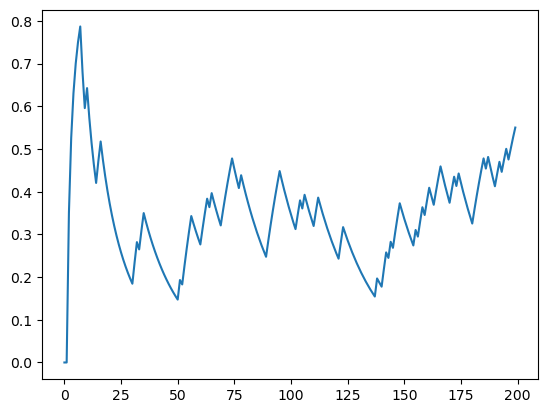

In [10]:
l = 0.95
choice1 = outs[:, 0]
ls = np.array([l**i for i in range(len(choice1))])
ones = np.ones(len(choice1))
wma = np.convolve(choice1, ls, mode='full') / np.convolve(ones, ls, mode='full')
wma = wma[:len(choice1)]
plt.plot(wma)

array([1.00000000e+00, 1.80000000e+00, 2.44000000e+00, 2.95200000e+00,
       3.36160000e+00, 3.68928000e+00, 3.95142400e+00, 4.16113920e+00,
       4.32891136e+00, 4.46312909e+00, 4.57050327e+00, 4.65640262e+00,
       4.72512209e+00, 4.78009767e+00, 4.82407814e+00, 4.85926251e+00,
       4.88741001e+00, 4.90992801e+00, 4.92794241e+00, 4.94235392e+00,
       4.95388314e+00, 4.96310651e+00, 4.97048521e+00, 4.97638817e+00,
       4.98111053e+00, 4.98488843e+00, 4.98791074e+00, 4.99032859e+00,
       4.99226287e+00, 4.99381030e+00, 4.99504824e+00, 4.99603859e+00,
       4.99683087e+00, 4.99746470e+00, 4.99797176e+00, 4.99837741e+00,
       4.99870193e+00, 4.99896154e+00, 4.99916923e+00, 4.99933539e+00,
       4.99946831e+00, 4.99957465e+00, 4.99965972e+00, 4.99972777e+00,
       4.99978222e+00, 4.99982578e+00, 4.99986062e+00, 4.99988850e+00,
       4.99991080e+00, 4.99992864e+00, 4.99994291e+00, 4.99995433e+00,
       4.99996346e+00, 4.99997077e+00, 4.99997662e+00, 4.99998129e+00,
      